# Avaliação da Explicabilidade com GradCAM

In [42]:
# Importações de libraries importantes
import sys
sys.path.append('../')
from neuroscan import modelo
from neuroscan import grad_cam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [43]:
# Modelo NeuroscanSUS pretreinado
modelo = tf.keras.models.load_model("../neuroscan/modelos/modelo.h5")

# Mapa de Classes
classes_mapa = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'sem_tumor', 3: 'pituitario_tumor'}

In [44]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 399, 399, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 198, 198, 16)      4112      
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 198, 198, 16)      0

In [45]:
gradcam = grad_cam.GradCAM(modelo, "conv2d_1")

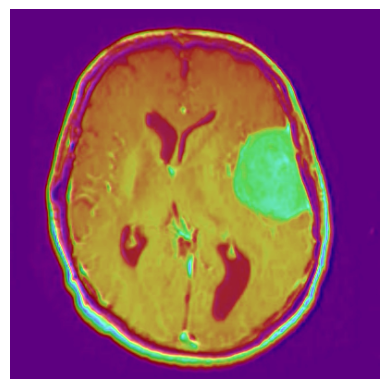

In [61]:
path = "../neuroscan/dados/Testing/meningioma_tumor/image(32).jpg"
gradcam.faz_gradcam(path_da_imagem=path)

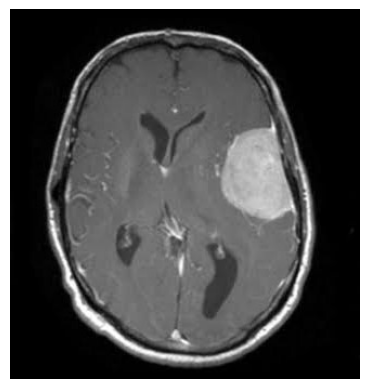

In [62]:
imagem = Image.open(path)
plt.imshow(imagem)
plt.axis("off")
plt.show()

In [63]:
imagem = np.array(imagem.resize((400, 400)))
imagem = np.expand_dims(imagem, axis=0)

In [64]:
print(np.argmax(modelo.predict(imagem), axis=-1))

1/1 [==============================] - 0s 63ms/step
[1]


In [65]:
print(modelo.predict(imagem))

1/1 [==============================] - 0s 67ms/step
[[0.15837967 0.4109049  0.28600731 0.14470808]]
